## Closing budgets for thickness, heat, salt and biogeochemical tracers
All done on the native grid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gsw
import budgetcalcs as bc

In [5]:
# 08990101.heat_salt_o2.1year/
# rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/4/history/'
# rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025_6h/'
rootdir = '/archive/gam/MOM6-gm/ocean_only/box/dev_core/'
# filename = '19000101.ocean_daily.nc'
# filename = '08990101.ocean_5daily_z_08*.nc'
filename = 'ocean_6hourly.nc'
# ds = xr.open_mfdataset(rootdir+filename,combine='by_coords').isel(time=0)
ds = xr.open_dataset(rootdir+filename).isel(time=0)

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [14]:
# h_terms = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency','boundary_forcing_h_tendency','internal_heat_h_tendency']
heat_terms = ['opottemptend','T_advection_xy','Th_tendency_vert_remap','boundary_forcing_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
# salt_terms = ['osalttend','S_advection_xy','Sh_tendency_vert_remap','boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
# o2_terms = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']
# no3_terms = ['no3h_tendency','no3_advection_xy','no3h_tendency_vert_remap','no3_dfxy_cont_tendency','no3_vdiffuse_impl','jno3']

# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
rho0=1035.0

# # Close oxygen budget
# o2_tend = o2_terms[0]
# # Correct MOM6 tendencies to account for mass in cell
# # i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
# for term in o2_terms[:-1]:
#     ds[term] *= rho0
# # Close nitrate budget   
# no3_tend = no3_terms[0]
# for term in no3_terms[:-1]:
#     ds[term] *= rho0
    
### THIS A HACK WHILE I WORK OUT THE VDIFFUSE_IMPL TERMS ###
# Calculate residual error
# OXYGEN
# tendsum,error = bc.calc_budget(ds,o2_terms[1:],o2_terms[0],plot=False)
# ds['o2_vdiffuse_impl']=error
# tendsum,error = bc.calc_budget(ds,no3_terms[1:],no3_terms[0],plot=False)
# ds['no3_vdiffuse_impl']=error

# ds['o2h_tendency'] *= rho0
# ds['o2h_tendency_vert_remap'] *= rho0
# ds['o2_advection_xy'] *= rho0
# ds['o2_dfxy_cont_tendency'] *= rho0
# ds['o2_vdiffuse_impl'] *= rho0
# # Remove bottom boundary flux from jo2_plus_btm (already included in o2_vdiffuse_impl)
# jo2_btm = xr.zeros_like(ds.jo2_plus_btm)
# jo2_btm.loc[dict(zl=ds.zl.max())]=ds.o2_btf
# jo2 = ds.jo2_plus_btm - jo2_btm
# jo2.name = 'jo2'
# ds = xr.merge([ds,jo2])
# # HACK SURFACE FLUX FOR NOW #
# ds['o2h_tendency_stf'] = ds['o2h_tendency']-(ds['o2h_tendency_vert_remap']+
#                                               ds['o2_advection_xy']+
#                                               ds['o2_dfxy_cont_tendency']+
#                                               ds['o2_vdiffuse_impl']+
#                                               ds['jo2'])

In [15]:
# Take some subsamples of the output
prof = ds.sel(xh=-150,yh=20,method='nearest').squeeze()
layer = ds.sum(dim=['xh','yh']).squeeze()
slic = ds.sel(zl=100,method='nearest').squeeze()
ksum = ds.sum(dim='zl').squeeze()

***

### Thickness

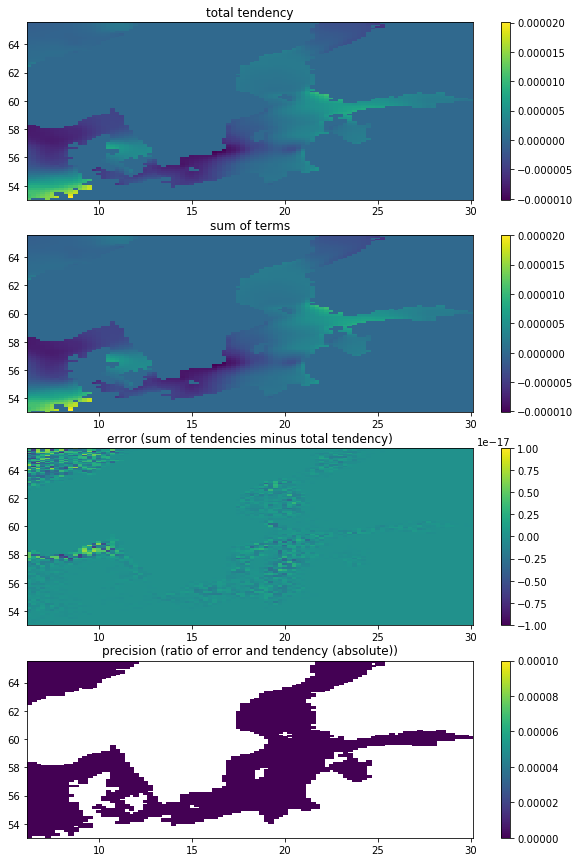

In [12]:
tend_sum,error = bc.calc_budget(ksum,h_terms[1:],h_terms[0],omit=['internal_heat_h_tendency'],errors=[-1E-17,1E-17])

***
### Oxygen
#### Vertical sum

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


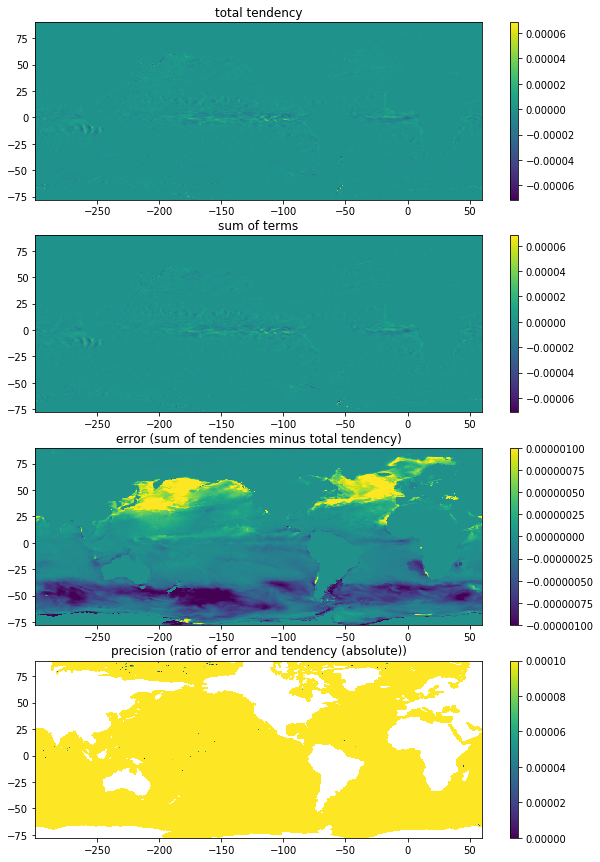

In [15]:
# Oxygen
tend_sum, error = bc.calc_budget(ksum,o2_terms[1:],o2_terms[0],errors=[-1E-6,1E-6])

#### Single profile

(<Figure size 360x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b0b4d5fd7b8>)

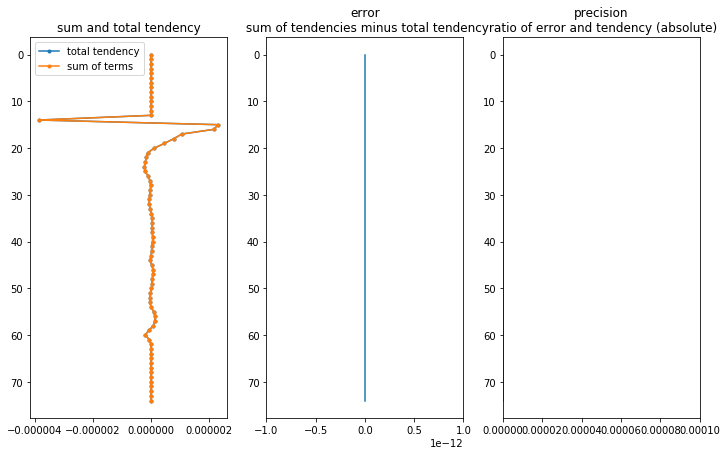

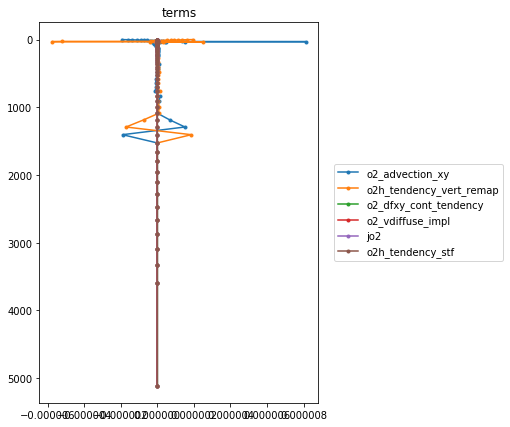

In [8]:
tend_sum, error = bc.calc_budget(prof,o2_terms,tend,omit=[],errors=[-1E-12,1E-12])
bc.plot_budgetterms(prof,o2_terms)

#### Material derivative balanced by diffusion and source/sink terms

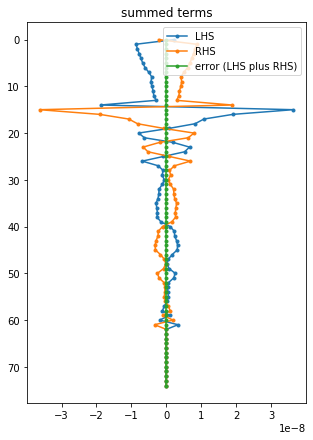

In [11]:
termsLHS = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap']
signsLHS = [-1,1,1]
termsRHS = ['o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2','o2h_tendency_stf']
signsRHS = [1,1,1,1]
bc.calc_materialderivative(prof,termsLHS,signsLHS,termsRHS,signsRHS);

***
### Nitrate
#### Vertical sum

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


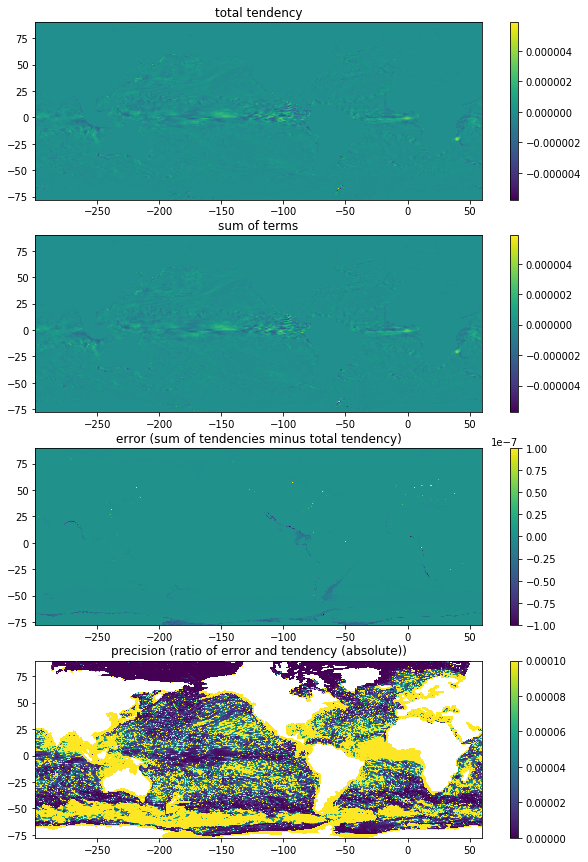

In [11]:
# Nitrate
tend_sum, error = bc.calc_budget(ksum,no3_terms[1:],no3_terms[0],errors=[-1E-7,1E-7])

#### Single profile

(<Figure size 360x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b0732734cd0>)

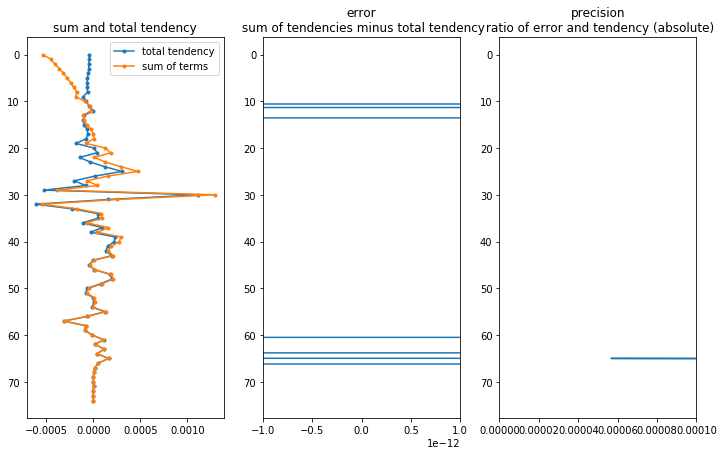

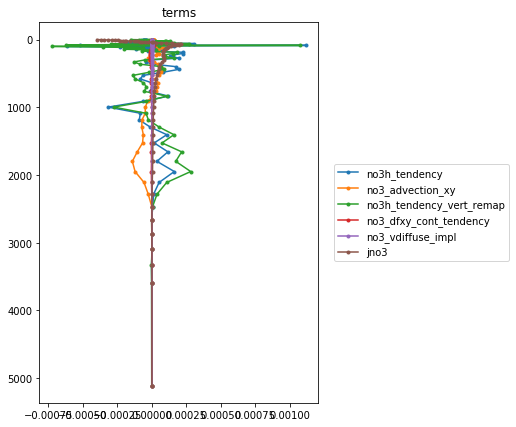

In [10]:
tend_sum, error = bc.calc_budget(layer,no3_terms[1:],no3_terms[0],omit=[],errors=[-1E-12,1E-12])
bc.plot_budgetterms(layer,no3_terms)

#### Material derivative balanced by diffusion and source/sink terms

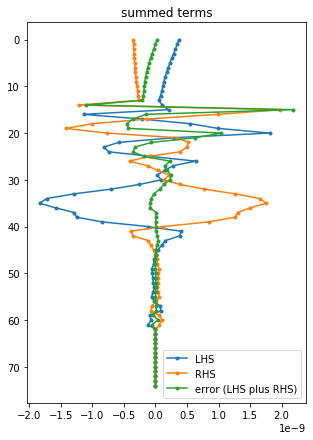

In [9]:
termsLHS = no3_terms[:3]
signsLHS = [-1,1,1]
termsRHS = no3_terms[3:]
signsRHS = [1,1,1]
bc.calc_materialderivative(prof,termsLHS,signsLHS,termsRHS,signsRHS);

***
### Heat
#### Vertical sum

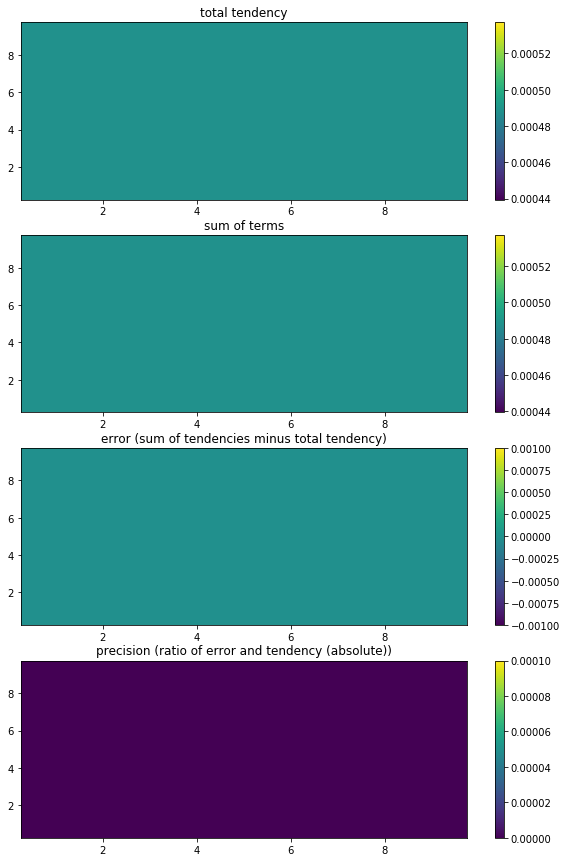

In [16]:
# Heat
tend_sum, error = bc.calc_budget(ksum,heat_terms[1:],heat_terms[0],errors=[-1E-3,1E-3])

#### Single profile

(<Figure size 360x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b298a6bd760>)

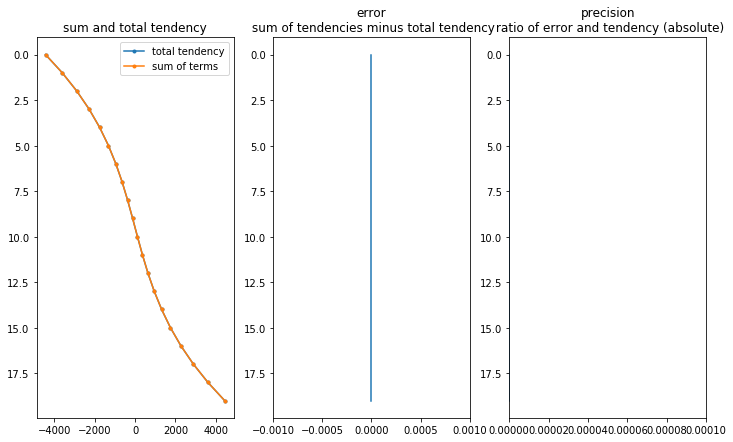

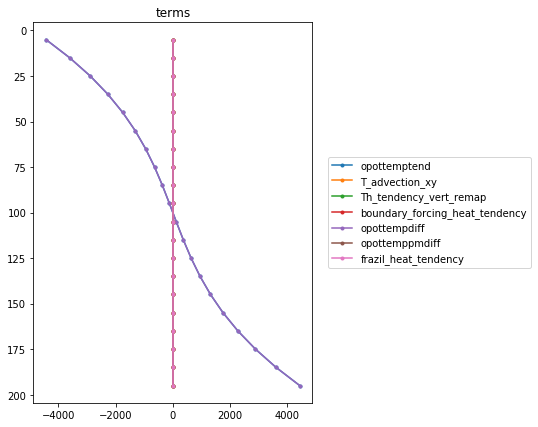

In [24]:
tend_sum, error = bc.calc_budget(prof,heat_terms[1:],heat_terms[0],omit=[],errors=[-1E-3,1E-3])
bc.plot_budgetterms(prof,heat_terms)

#### Material derivative balanced by diffusion and source/sink terms

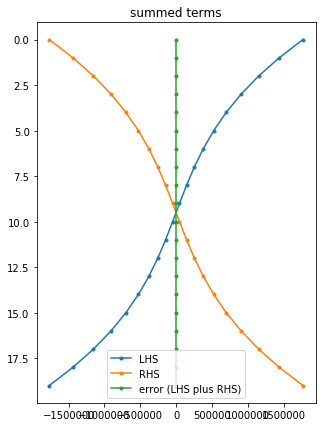

In [26]:
termsLHS = ['opottemptend','T_advection_xy','Th_tendency_vert_remap']
signsLHS = [-1,1,1]
termsRHS = ['boundary_forcing_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
signsRHS = [1,1,1,1,1]
Dheat,dheat,error = bc.calc_materialderivative(layer,termsLHS,signsLHS,termsRHS,signsRHS,plot=True)
fig = plt.gcf()
fig.savefig('figures/budgetclose_native',transparent=True,dpi=600)

***
### Salt
#### Vertical sum

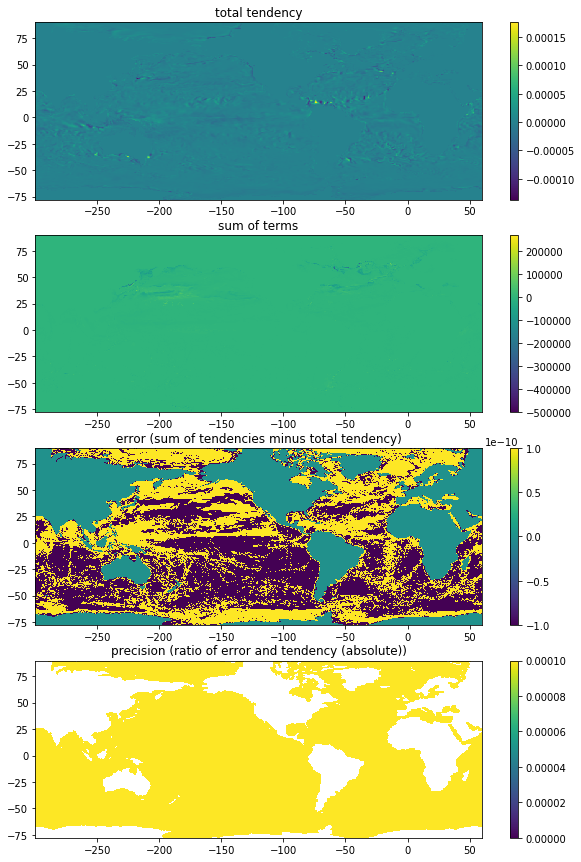

In [3]:
# Salt
tend_sum, error = bc.calc_budget(ksum,salt_terms,tend,omit=[],errors=[-1E-10,1E-10])

#### Single profile

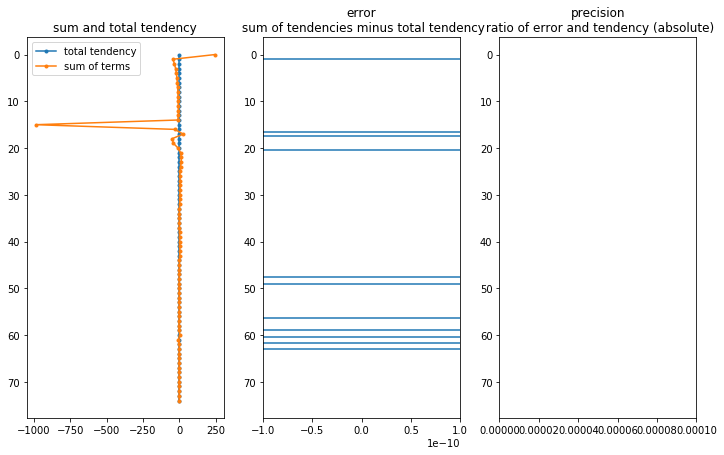

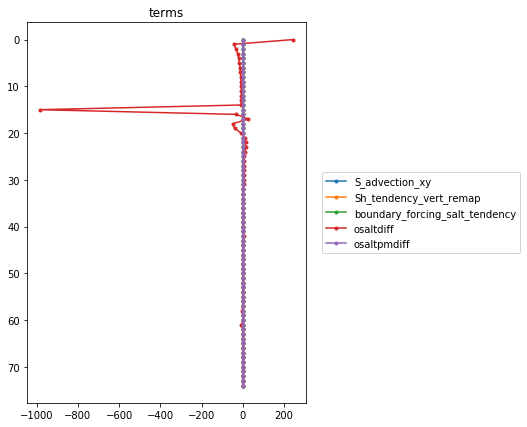

In [4]:
tend_sum, error = bc.calc_budget(prof,salt_terms,tend,omit=[],errors=[-1E-10,1E-10])
bc.plot_budgetterms(prof,salt_terms,omit=[])

In [ ]:
termsLHS = ['osalttend','S_advection_xy','Sh_tendency_vert_remap']
signsLHS = [-1,1,1]
termsRHS = ['boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
signsRHS = [1,1,1]
bc.calc_materialderivative(prof,termsLHS,signsLHS,termsRHS,signsRHS,plot=True)

In [12]:
tend

'osalttend'